In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 8
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
CHANNELS= 3
CLASSES = 6
EPOCHS= 500

In [4]:
# Directory with the images
data_dir = "Multiple_Class_Eras_Tour"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 508 files belonging to 6 classes.


In [5]:
# Name of the classes
class_names = dataset.class_names
print(class_names)

['1_Fearless', '2_Speak_Now', '3_Lover', '4_Reputation', '5_TTPD', '6_Folkmore']


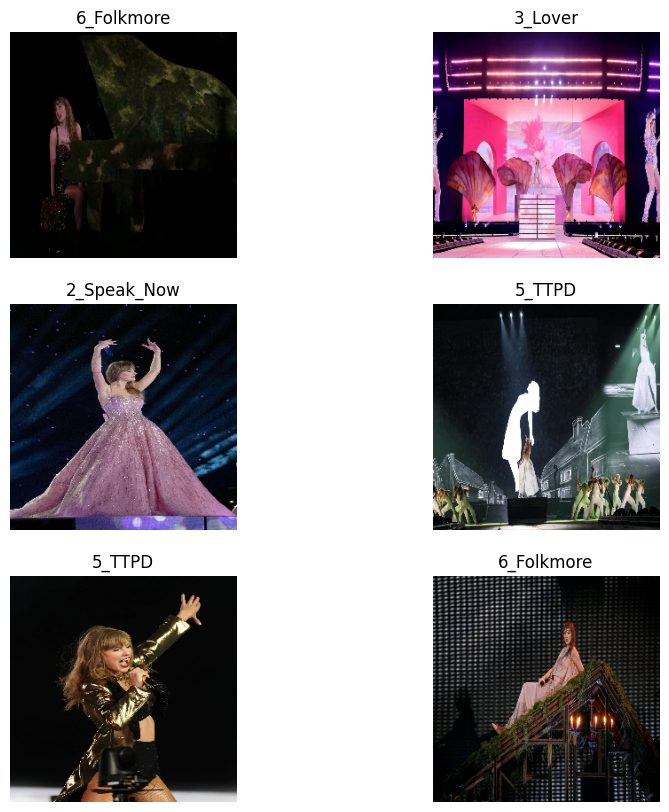

In [6]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# Display the shape of batched train samples
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 256, 3)
(8,)


In [8]:
def subset_creation(dataset, train_split=0.7, test_split=0.1, val_split=0.2, shuffle=True, shuffle_size=100):

    assert (train_split + test_split + val_split) == 1

    size_dataset = len(dataset)

    if shuffle:
            dataset = dataset.shuffle(shuffle_size, seed=123)
    
    train_size = int(size_dataset * train_split)
    test_size = int(size_dataset * test_split)
    val_size = int(size_dataset * val_split)


    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(test_size).take(val_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_ds, val_ds, test_ds = subset_creation(dataset)

In [10]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 44
        - val split: 12
        - test split: 6
    ----------------------------------
    


In [11]:
#Caching the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Normalize and rescale the images
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [13]:
# Proof that the images are rescaled
normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
# Import keras api 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
  tf.keras.layers.RandomContrast(0.5),
  #tf.keras.layers.RandomCrop(height=1, width=1),
  #tf.keras.layers.RandomZoom(0.2),
  #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  #tf.keras.layers.RandomBrightness(factor=0.2)
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=128,  kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (8, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 254, 254, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 127, 127, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (8, 127, 127, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 125, 125, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 62, 62, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (8, 62, 62, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 60, 60, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 30, 30, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (8, 30, 30, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (8, 28, 28, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (8, 14, 14, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (8, 14, 14, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (8, 12, 12, 64)        │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (8, 6, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (8, 6, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (8, 4, 4, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (8, 2, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (8, 2, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 6)                 │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,974 (1.37 MB)

 Trainable params: 359,974 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
filepath="saved_models/best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=20)
callbacks_list = [checkpoint, es]

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

In [ ]:
filepath = "saved_models\\base_model.keras"
best_model = tf.keras.models.load_model(filepath)

In [ ]:
scores = best_model.evaluate(test_ds)

In [ ]:
print("Accuracy: %.2f%%"% (scores[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
EPOCHS = 99

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = best_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = best_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

As we can see the model has some trouble finding the right classes, some hypothesis can emerge from this base_model prediction:\
- This can be from the fact that we have a data inbalance in the dataset for 2 different classes
- Maybe we don't use the right metrics (ROC, F1-score are maybe better than accuracy)

To improve our base model we can start by showing/visualizing the data imbalance that the dataset has for different classes

In [ ]:
import os
import seaborn as sns
main_folder = 'Multiple_Class_Eras_Tour'

In [ ]:
era_counts = {}

# Iterate through each subfolder (era)
for era_folder in os.listdir(main_folder):
    era_path = os.path.join(main_folder, era_folder)
    if os.path.isdir(era_path):
        # Count the number of images in the era folder
        era_counts[era_folder] = len([filename for filename in os.listdir(era_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Create a pandas DataFrame from the era_counts dictionary
import pandas as pd
df = pd.DataFrame({'Era': era_counts.keys(), 'Image Count': era_counts.values()})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = sns.barplot(x='Era', y='Image Count', data=df, palette='flare')  # Choose a color palette you like
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar])
# Customize the plot
plt.title('Data Imbalance in Taylor Swift Eras Tour Images', fontsize=16)
plt.xlabel('Eras', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()

As we can see, the Reputation and TTPD classes have significantly less data than the other classes

In [19]:
def create_list_y(dataset, model):
  y_true = []
  y_pred = []

  for x, y in dataset:
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
  y_pred = tf.concat(y_pred, axis=0)
  y_true = tf.concat(y_true, axis=0)

  return y_pred, y_true

TEST DATASET

Confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Fearless", "Speak Now", "Lover", "Reputation", "TTPD", "Folkmore"]

y_pred, y_true = create_list_y(test_ds)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

Classification report

Observations:
- The classes Speak Now, Lover and Folkmore have the F1-score which means that these classes have the best harmonic mean of precision and recall

As already seen, the dataset is imbalanced so we can try the approach of changing the weights of the classes to increase the values of the classes with lower appearances\
We will try the Inverse number of sample technique first and see the improvement




In [20]:
def get_weight_inverse_num_samples(num_of_classes, samples_per_classes, coeff=1):
    """
    Get the inverse number of samples for each class.
    Args:
        num_of_classes (int): Number of classes in the dataset.
        samples_per_classes (list): List of number of samples per class.
        power (int, optional): Power of the inverse number of samples. Defaults to 1.
    Returns:
        list: List of inverse number of samples for each class.
    """

    inverse_num_samples = []
    total_samples = sum(samples_per_classes)

    for i in range(num_of_classes):
        inverse_num_samples.append((total_samples / (num_of_classes * samples_per_classes[i])) * coeff)

    return inverse_num_samples

num_of_classes = 6
samples_per_classes = [101, 100, 100, 68, 39, 100] 

weighted_classes = get_weight_inverse_num_samples(num_of_classes, samples_per_classes)


In [21]:
weighted_classes

[0.8382838283828383,
 0.8466666666666667,
 0.8466666666666667,
 1.2450980392156863,
 2.1709401709401708,
 0.8466666666666667]

In [22]:
class_indexes = [1, 2, 3, 4, 5, 6]

In [23]:
weights = dict(zip(class_indexes, weighted_classes))

In [24]:
weights

{1: 0.8382838283828383,
 2: 0.8466666666666667,
 3: 0.8466666666666667,
 4: 1.2450980392156863,
 5: 2.1709401709401708,
 6: 0.8466666666666667}

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [26]:
filepath="saved_models/best_weighted_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=20)
callbacks_list = [checkpoint, es]

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight=weights
)

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2658 - loss: 2.0563
Epoch 1: val_accuracy improved from -inf to 0.23958, saving model to saved_models/best_weighted_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.2645 - loss: 2.0562 - val_accuracy: 0.2396 - val_loss: 1.7788
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2014 - loss: 1.9783
Epoch 2: val_accuracy did not improve from 0.23958
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.2013 - loss: 1.9774 - val_accuracy: 0.2396 - val_loss: 1.7151
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.1543 - loss: 1.8908
Epoch 3: val_accuracy did not improve from 0.23958
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.1550 - loss: 1.8904 - val_accuracy: 0.2396 - val_loss: 1.7077
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2457 - loss: 1.9446
Epoch 4: val_accuracy did not improve from 0.23958
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step

In [28]:
filepath = "saved_models\\best_weighted_model.keras"
weighted_model = tf.keras.models.load_model(filepath)

In [29]:
scores = weighted_model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9217 - loss: 0.4341


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


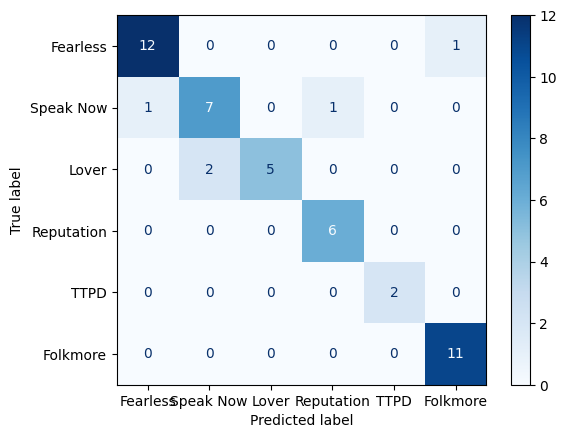

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Fearless", "Speak Now", "Lover", "Reputation", "TTPD", "Folkmore"]

y_pred, y_true = create_list_y(test_ds, weighted_model)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Fearless       0.92      0.92      0.92        13
   Speak Now       0.78      0.78      0.78         9
       Lover       1.00      0.71      0.83         7
  Reputation       0.86      1.00      0.92         6
        TTPD       1.00      1.00      1.00         2
    Folkmore       0.92      1.00      0.96        11

    accuracy                           0.90        48
   macro avg       0.91      0.90      0.90        48
weighted avg       0.90      0.90      0.89        48

